# Test Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline
from tqdm import tqdm

### Read raw test data

In [2]:
amazon = pd.read_csv('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/amazon_data/raw_data_test.csv')

print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.loc[0, "Text"])

strong taste but good! In my opinion it's not exactly a substitute for coffee but tastes really good mixed together.


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      207103        112082  112083  B002Y2QT2K  A22Y5TJPN98DWB   
1      139933        224640  224641  B009D53XKC  A3MDY6Y3Z6D649   
2       76100        399707  399708  B005GIF5WY  A3LCQXQ4SFYBAU   
3      114178        567900  567901  B005K4Q68Q  A2E65ZXD654761   
4      285272        263134  263135  B002WW3BW8  A1XAZ0MR4TRY16   

                  ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                Eva Juergens                     1                       1   
1  The Man Behind the Curtain                     1                       1   
2                  Johna Jane                     0                       0   
3                   Barbara L                     0                       0   
4                        bfn1                     0                       0   

   Score        Time                          Summary  \
0      3  1339286400                 chicory "coffee"   
1      5

In [5]:
##study chat

print(amazon[(amazon.helpful == True) &  (amazon.HelpfulnessNumerator>=5)] )

       Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
7           74160        306680  306681  B000KNB0OW  A1UQBFCERIP7VJ   
14         235629        224160  224161  B0002ARQYQ  A2T90OFSZ5QVE8   
19         261341        100841  100842  B000O3EDA6  A1VPUK22B4MTDE   
20         218022        107544  107545  B007TJGY4Q  A153ZN281OATI6   
28         348320        246292  246293  B0009F3SB4  A23C3X5UGN7KMN   
43         398064        506166  506167  B001CWVZUY  A1UKN7G4AM275R   
57         268338        352657  352658  B000U3H4PQ   AYB4ELCS5AM8P   
64          14378        464995  464996  B002EDIJCM  A191T1D7JURDMI   
83         306766        551822  551823  B003RDFJ6C  A3NID9D9WMIV01   
148        159725         45277   45278  B000OV5NBG  A3OQGS2G48ZURR   
175         34171        417148  417149  B00112ILZM  A3FNMPXHHIVEYT   
181         24886        447330  447331  B000GZU900  A1WXJ1I42UOQ2V   
191        183906        394423  394424  B00269VK20  A154PTQXC5FFKH   
202   

In [6]:
# from gensim.parsing.preprocessing import remove_stopwords
# # remove stop words in amazon.Text
# amazon['Text'] = amazon['Text'].apply(remove_stopwords)
# #newText = amazon['Text'].apply(remove_stopwords)
# print(amazon.Text)

In [7]:
#Lemmatization 
from gensim.utils import lemmatize
print('**************************************************')
amaLemma=[]
for w in tqdm(amazon['Text']):
    amaLemma.append([wd.decode('utf-8').split('/')[0] for wd in lemmatize(w)])

  0%|          | 0/91000 [00:00<?, ?it/s]

**************************************************


100%|██████████| 91000/91000 [11:09<00:00, 136.01it/s]


In [8]:
amaNp=np.array(amaLemma)
amaDF=pd.DataFrame(amaNp)

amaDF.to_csv('/Users/working/Documents/ParsonsSchool/Sp19/MachineLearning/DATASET/amazon_data/AmazonLemmatizedTestingwithStopWords.csv')
print(amaDF)

                                                       0
0      [strong, taste, good, opinion, not, exactly, s...
1      [search, high, low, salt, change, life, end, j...
2      [treat, be, picky, cat, favorite, ve, try, dif...
3      [price, be, fantastic, taste, so, convenient, ...
4      [alot, chocolate, not, so, much, coffee, bean,...
5      [look, ingredient, water, wheat, salt, sugar, ...
6      [love, love, bread, mix, person, be, raise, ea...
7      [country, choice, brand, be, domestically, pro...
8      [taste, good, easy, prepare, separate, pouch, ...
9      [only, recently, have, discover, satisy, inter...
10     [always, enjoy, tazo, tea, earl, grey, be, fav...
11     [be, skeptical, sister, tell, drug, rep, have,...
12     [have, grand, kid, fall, play, ground, equipme...
13     [guess, get, title, wrong, be, food, left, be,...
14     [buy, mini, buster, cube, miniature, dachshund...
15     [ll, confess, know, little, different, coffee,...
16     [be, thrill, find, flavo

In [9]:
#JOIN LIST TO STR


amaDFOut = amaDF[0].apply(' '.join)
print(amaDFOut.head())


0    strong taste good opinion not exactly substitu...
1    search high low salt change life end journey m...
2    treat be picky cat favorite ve try different b...
3    price be fantastic taste so convenient make me...
4    alot chocolate not so much coffee bean not big...
Name: 0, dtype: object


### Feature extraction on natural language data

In [10]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())
hv = joblib.load('vectorizer.pkl')
X_hv = hv.transform(amaDFOut)
print(X_hv.shape)

(91000, 76362)


In [11]:
# # vectorize Bag of Words from review text; as sparse matrix
# # from sklearn.feature_extraction.text import HashingVectorizer
# # hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
# hv = joblib.load('hv.pkl')
# #X_hv = hv.transform(amazon.Text)
# X_hv = hv.transform(amaDFOut)
# print(X_hv.shape)
# # print(hv.shape)

In [12]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [13]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Time Converting 

In [14]:
import datetime

amazon['amaRead'] = amazon['Time'].apply(datetime.datetime.fromtimestamp)
amazon['amaHour'] = amazon['amaRead'].apply(datetime.datetime.strftime, format=("%H"))
amazon['amaHour'] = amazon['amaHour'].apply(int)
amazon['amaDay'] =amazon['amaRead'].apply(datetime.datetime.weekday)

print(amazon['amaHour'].head(10))
print(amazon['amaDay'].head(10))

0    20
1    19
2    20
3    20
4    20
5    20
6    20
7    19
8    20
9    19
Name: amaHour, dtype: int64
0    5
1    1
2    6
3    1
4    6
5    2
6    0
7    4
8    0
9    6
Name: amaDay, dtype: int64


### Create additional quantitative features

In [15]:
# features from Amazon.csv to add to feature set
# amazon['reviewLen'] = amazon['Text'].str.len()
amazon['reviewLen'] = amaDFOut.str.len()
# X_quant_features = amazon[["Score", "reviewLen"]]
X_quant_features = amazon[["Score", "reviewLen","amaDay","amaHour"]]


print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen  amaDay  amaHour
0      3         88       5       20
1      5       1911       1       19
2      5         97       6       20
3      5        109       1       20
4      3         90       6       20
5      1        133       2       20
6      5        428       0       20
7      5        792       4       19
8      5         59       0       20
9      5        390       6       19
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [16]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 76366)


### Create `X`, scaled matrix of features

In [17]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 76366)


### create `y`, vector of Labels

In [18]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [19]:
# MODEL: ordinary least squares
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X, y)
# joblib.dump(ols, 'ols.pkl') # pickle
ols = joblib.load('ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 3081, 'TN': 46032, 'FP': 38361, 'FN': 3526, 'Accuracy': 0.5397032967032968, 'Precision': 0.07434486752569856, 'Recall': 0.4663235961858635, 'desc': 'ols'}


In [20]:
# MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1062, 'TN': 82221, 'FP': 2172, 'FN': 5545, 'Accuracy': 0.9151978021978022, 'Precision': 0.32838589981447125, 'Recall': 0.16073861056455274, 'desc': 'svm'}


In [21]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1691, 'TN': 80899, 'FP': 3494, 'FN': 4916, 'Accuracy': 0.9075824175824175, 'Precision': 0.32613307618129217, 'Recall': 0.25594066898743756, 'desc': 'lgs'}


In [22]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 2431, 'TN': 73436, 'FP': 10957, 'FN': 4176, 'Accuracy': 0.8337032967032967, 'Precision': 0.181580519868539, 'Recall': 0.3679430906614197, 'desc': 'nbs'}


In [23]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 2452, 'TN': 72710, 'FP': 11683, 'FN': 4155, 'Accuracy': 0.8259560439560439, 'Precision': 0.1734701096568801, 'Recall': 0.3711215377629787, 'desc': 'prc'}


In [24]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 907, 'TN': 83210, 'FP': 1183, 'FN': 5700, 'Accuracy': 0.9243626373626374, 'Precision': 0.43397129186602873, 'Recall': 0.13727864386257, 'desc': 'rdg'}


In [25]:
# MODEL: Decision Tree Classifier
# from sklearn import tree
# dtc = tree.DecisionTreeClassifier(max_depth=100)
# dtc.fit(X_matrix, y)
# joblib.dump(dtc, 'dtc.pkl') # pickle
dtc = joblib.load('dtc.pkl')

dtc_performance = BinaryClassificationPerformance(dtc.predict(X_matrix), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 6607, 'Neg': 84393, 'TP': 1511, 'TN': 83300, 'FP': 1093, 'FN': 5096, 'Accuracy': 0.931989010989011, 'Precision': 0.5802611367127496, 'Recall': 0.22869683668836083, 'desc': 'dtc'}


### ROC plot to compare performance of various models and fits

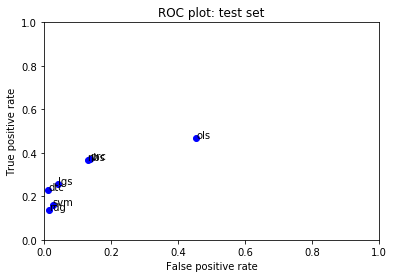

In [26]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance, ols_performance, dtc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ridge Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [30]:
amazon.loc[0, "Text"]

"strong taste good! In opinion it's exactly substitute coffee tastes good mixed together."

In [31]:
amazon.loc[0, "helpful"]

False

In [32]:
ridge_predictions = rdg.predict(X)

In [33]:
ridge_predictions.shape

(91000,)

In [34]:
print(ridge_predictions)

[False False False ... False False False]


In [35]:
# false positives

import random, time

for i in range(0, len(ridge_predictions)):
    if (ridge_predictions[i] == True):
        if (amazon.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazon.loc[i, "Time"])))
                print(amazon.loc[i, "Score"])
                print(amazon.loc[i, "HelpfulnessDenominator"])
                print(amazon.loc[i, "ProductId"])
                print(amazon.loc[i, "Text"])
                print('* * * * * * * * * ')

7427
2012-09-15 00:00:00
5
1
B003XUHGRO
nice good neat cool great amazing fantastic stupendous exceptional review process complete bore useless. Let Check number Stars leave field optional.
* * * * * * * * * 
7730
2012-06-01 00:00:00
4
0
B007RTR89S
I color-treated (all-over blonde highlights) fine hair... lot it! I originally tried volumizing shampoo condition Clear I needed moisture. This great!<br /><br />Even washing hair manageable, styled better, shiney bright! One guys I work said looked blonder asked I got done!<br /><br />I know sulfate hair looks great anyway!
* * * * * * * * * 
8649
2012-06-11 00:00:00
5
0
B00390T5JA
Simple use, intuitive set up. Makes great coffee tea, provided use preferred brands. Fits kitchen counter, extra space, reservoir holds decent water cup, provide cups guests filling reservoir over. Great item.
* * * * * * * * * 
9863
2011-02-11 00:00:00
4
1
B000FI4O90
I received Aerogarden half weeks ago thrilled it. The reason I given stars I think expensive, pa